In [16]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from mlp_explainer.synthetic_data import SyntheticData

#### 1. Define Ground Truth Bayesian Network

In [31]:
identifier = 'experiment_2'
experiment = SyntheticData(identifier)

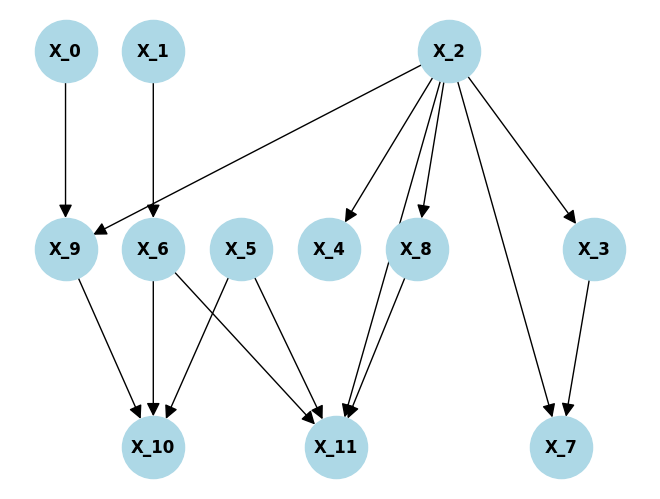

In [32]:
experiment.draw_network()

#### 2. Sample Sufficient Dataset From Ground Truth Bayesian Network

In [33]:
experiment.create_dataset()
experiment.save()

In [35]:
data = pd.read_csv(f'data/{identifier}_ground_data.csv')
data

,X_0,X_9,X_1,X_6,X_2,X_3,X_4,X_7,X_8,X_11,X_5,X_10
0,1.235977,1.244315,-1.490701,-0.650691,-1.321525,-2.038625,-2.421698,1.371869,1.654605,-1.749257,-1.776743,-1.271827
1,-0.389506,1.408974,-0.434981,-0.853145,-1.397793,-0.484505,-0.652491,2.158322,-0.273002,0.854644,-3.468140,0.330752
2,0.518672,1.272258,-0.561135,-0.973712,-0.908557,-2.961816,-0.815564,-0.057406,0.555206,-1.991801,-2.057277,0.371611
3,2.101239,1.599207,-0.346673,-0.623628,-1.485023,3.197990,-0.864681,1.722973,3.083826,1.486425,-1.385477,-3.909379
4,0.978429,1.380649,-0.730340,-0.834450,-0.994969,-0.281202,-1.608407,1.352439,1.706245,-1.232339,-3.257603,-1.679385
...,...,...,...,...,...,...,...,...,...,...,...,...
16379,1.360771,1.707403,-3.313560,-0.996999,-1.479634,-1.294214,-4.854316,2.319699,5.385700,-3.581113,-3.040568,-2.591182
16380,-1.233152,1.601070,-2.824843,-0.681709,-1.346101,-2.351541,-4.201747,2.792997,-1.039166,-2.292176,-1.529712,-1.480080
16381,0.872303,1.579832,0.471739,0.049891,-1.426090,-3.550051,0.286516,0.254194,2.819382,-0.172340,-2.447750,-3.297596
16382,-0.292710,1.299927,-0.023217,-0.666842,-1.414064,0.841882,-0.608265,1.693827,0.722318,1.671756,-3.596235,-1.920398


#### 3. Choose Target Variable From Bayesian Network Variables And Split Data

In [36]:
target_node = None
max_in_degree = -1
leaf_nodes = list(experiment.model.get_leaves())
in_degree_iterator = experiment.model.in_degree_iter()

for node, in_degree in in_degree_iterator:
    if node in leaf_nodes and in_degree > max_in_degree:
        target_node = node
        max_in_degree = in_degree

print(f'Target Node: {target_node}')

Target Node: X_11


In [37]:
X_columns = [column for column in data.columns.tolist() if column != target_node]

X = data[X_columns].values
y = data[target_node].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (13107, 11) (13107,)
Test shape: (3277, 11) (3277,)


#### 4. Data Preprocessing

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### 5. Build And Train Model

In [39]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
if os.path.exists(model_filename):
    print(f"Skip Stage 5 & 6: {identifier} model already exists.")

In [41]:
model = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(32, activation = 'relu'),
    Dense(32, activation = 'sigmoid'),
    Dense(8, activation = 'relu'),
    Dense(1)  
])

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')

In [42]:
history = model.fit(X, y, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2648 - val_loss: 2.4648
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 2.3954 - val_loss: 2.4008
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 2.3545 - val_loss: 2.3815
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 2.3344 - val_loss: 2.3641
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 2.3280 - val_loss: 2.3619
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 2.3144 - val_loss: 2.3608
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 2.3054 - val_loss: 2.3672
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 2.3058 - val_loss: 2.3677
Epoch 9/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 2.2991 - val_loss: 2.3447
Epoch 10/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 2.2979 - val_loss: 2.4013
Epoch 11/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 2.2917 - val_loss: 2.3490
Epoch 12/50
410/410 ━━━━━━━━━━━━

#### 6. Report and Save Model Performance

In [43]:
loss = model.evaluate(X, y)
predictions = model.predict(X)
r2 = r2_score(y, predictions)

print(f"R² score: {r2:.4f}")
print(f"Final loss: {loss}")

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 2.2551
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
R² score: 0.5851
Final loss: 2.2550601959228516


In [44]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
model.save(model_filename)

#### 7. Save Random Instance To Explain

In [45]:
explaindata_filename = os.path.join("data", f"{identifier}_explaindata.npy")

if os.path.exists(explaindata_filename):
    print(f"Skip Stage 7: {identifier} explaindata already exists.")

In [46]:
y_test = y_test.reshape(-1, 1)
data = np.hstack((X_test, y_test))
num_rows = data.shape[0]
random_indices = np.random.choice(num_rows, size = 5, replace=False)
explaindata = data[random_indices]

In [47]:
np.save(explaindata_filename, explaindata)

#### 8. Generate Bayesian Network Explanation From EachExplain Data Instance